# **Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

df = pd.read_csv("/content/taxi_trip_pricing.csv")

# **EDA & Feature Engineering**

In [2]:
df.isnull().sum()

,0
Trip_Distance_km,50
Time_of_Day,50
Day_of_Week,50
Passenger_Count,50
Traffic_Conditions,50
Weather,50
Base_Fare,50
Per_Km_Rate,50
Per_Minute_Rate,50
Trip_Duration_Minutes,50


In [3]:
numerical_features = list(df.select_dtypes(exclude = 'object').columns)

for i in numerical_features:
  df[i].fillna(df[i].mean(), inplace=True)

In [4]:
categorical_features = list(df.select_dtypes(include ='object').columns)

for i in categorical_features:
  df[i].fillna(df[i].mode()[0], inplace=True)

In [5]:
df["Distance_Cost"] = df["Trip_Distance_km"] * df["Per_Km_Rate"]
df["Time_Cost"] = df["Trip_Duration_Minutes"] * df["Per_Minute_Rate"]
df["Total_Variable_Cost"] = df["Distance_Cost"] + df["Time_Cost"]
df["Avg_Speed_kmph"] = df["Trip_Distance_km"] / (df["Trip_Duration_Minutes"] / 60)
df["Fare_per_km"] = df["Trip_Price"] / df["Trip_Distance_km"]

In [6]:
df["Peak_Hour"] = df["Time_of_Day"].isin(["Morning", "Evening"]).astype(int)
df["Is_Weekend"] = (df["Day_of_Week"] == "Weekend").astype(int)
traffic_map = {"Low": 0, "Medium": 1, "High": 2}
df["Traffic_Level"] = df["Traffic_Conditions"].map(traffic_map)
df["Price_Intensity"] = df["Per_Km_Rate"] + df["Per_Minute_Rate"]
df["Congested_Trip"] = (df["Avg_Speed_kmph"] < 20).astype(int)

In [7]:
price_bins = pd.cut(df['Trip_Price'],bins=[0, 20, 40, 60, 100, 500],labels=['Very Low', 'Low', 'Medium', 'High', 'Premium'])

price_bins.value_counts().sort_index()

,count
Trip_Price,
Very Low,66
Low,254
Medium,340
High,281
Premium,59


In [8]:
df['Trip_Price'] = (df['Base_Fare'] + df['Trip_Distance_km'] * df['Per_Km_Rate'] + df['Trip_Duration_Minutes'] * df['Per_Minute_Rate'])

In [9]:
print(df.columns)

Index(['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
       'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price',
       'Distance_Cost', 'Time_Cost', 'Total_Variable_Cost', 'Avg_Speed_kmph',
       'Fare_per_km', 'Peak_Hour', 'Is_Weekend', 'Traffic_Level',
       'Price_Intensity', 'Congested_Trip'],
      dtype='object')


In [10]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Distance_Cost,Time_Cost,Total_Variable_Cost,Avg_Speed_kmph,Fare_per_km,Peak_Hour,Is_Weekend,Traffic_Level,Price_Intensity,Congested_Trip
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,54.872867,33.255001,18.114877,51.369877,42.358757,3.073210,0.486000,0.295000,0.735000,1.526232,0.404000
std,19.400775,1.074311,0.848107,0.418922,0.112662,31.339413,30.121946,28.028713,12.099411,30.098551,56.087715,3.368501,0.500054,0.456271,0.747887,0.436827,0.490943
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900,0.787400,0.791000,3.416900,0.691400,0.541589,0.000000,0.000000,0.000000,0.610000,0.000000
25%,13.107500,2.000000,2.770000,0.870000,0.197500,37.107500,34.566350,14.154750,8.884725,31.331400,13.137059,1.599168,0.000000,0.000000,0.000000,1.160000,0.000000
50%,26.995000,2.476842,3.502989,1.233316,0.292916,62.118116,51.012600,27.836532,15.133800,47.248087,25.125472,2.154506,0.000000,0.000000,1.000000,1.516458,0.000000
75%,37.782500,3.000000,4.202500,1.580000,0.382500,87.775000,68.370663,44.802900,25.407975,64.577325,46.268636,3.011905,1.000000,1.000000,1.000000,1.880000,1.000000
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,274.267274,253.093259,55.855000,272.027274,460.176678,37.173054,1.000000,1.000000,2.000000,2.460000,1.000000


In [11]:
def taxi_category(price):
    if price <= 30:
        return 'Economy'
    elif price <= 60:
        return 'Standard'
    elif price <= 100:
        return 'Premium'
    else:
        return 'Luxury'

df['Taxi_Category'] = df['Trip_Price'].apply(taxi_category)
df['Taxi_Category'].value_counts()

,count
Taxi_Category,
Standard,458
Premium,296
Economy,184
Luxury,62


In [12]:
df.head().T

,0,1,2,3,4
Trip_Distance_km,19.35,47.59,36.87,30.33,27.070547
Time_of_Day,Morning,Afternoon,Evening,Evening,Evening
Day_of_Week,Weekday,Weekday,Weekend,Weekday,Weekday
Passenger_Count,3.0,1.0,1.0,4.0,3.0
Traffic_Conditions,Low,High,High,Low,High
Weather,Clear,Clear,Clear,Clear,Clear
Base_Fare,3.56,3.502989,2.7,3.48,2.93
Per_Km_Rate,0.8,0.62,1.21,0.51,0.63
Per_Minute_Rate,0.32,0.43,0.15,0.15,0.32
Trip_Duration_Minutes,53.82,40.57,37.27,116.81,22.64


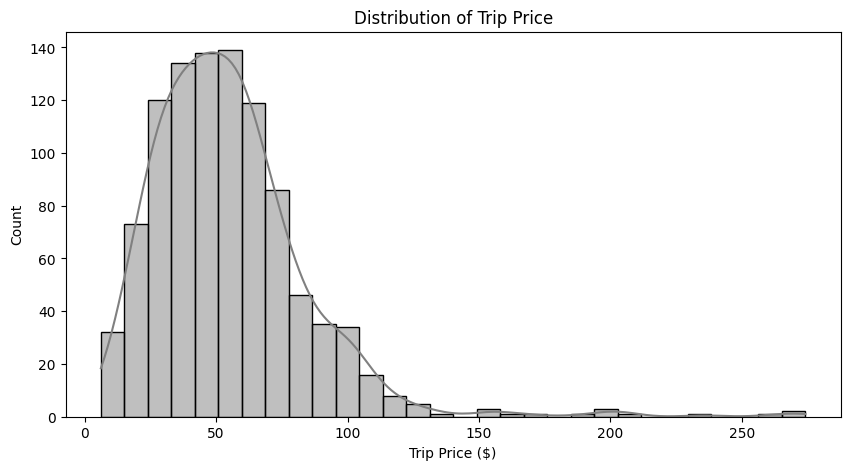

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(df['Trip_Price'], bins=30, kde=True, color='gray')
plt.title('Distribution of Trip Price')
plt.xlabel('Trip Price ($)')
plt.ylabel('Count')
plt.show()

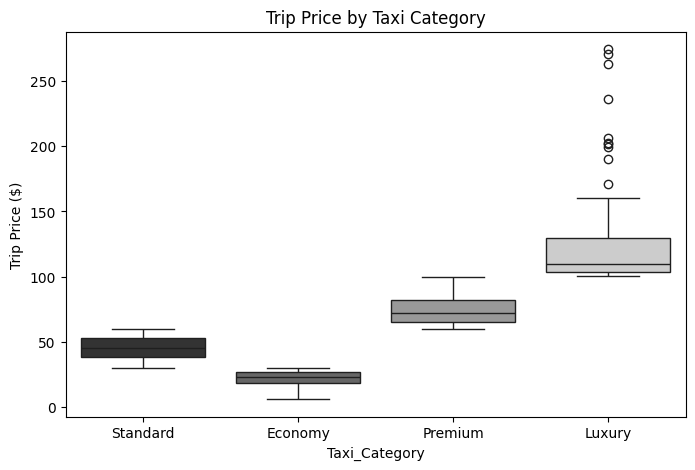

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Taxi_Category', y='Trip_Price', data=df, palette='gray')
plt.title('Trip Price by Taxi Category')
plt.ylabel('Trip Price ($)')
plt.show()

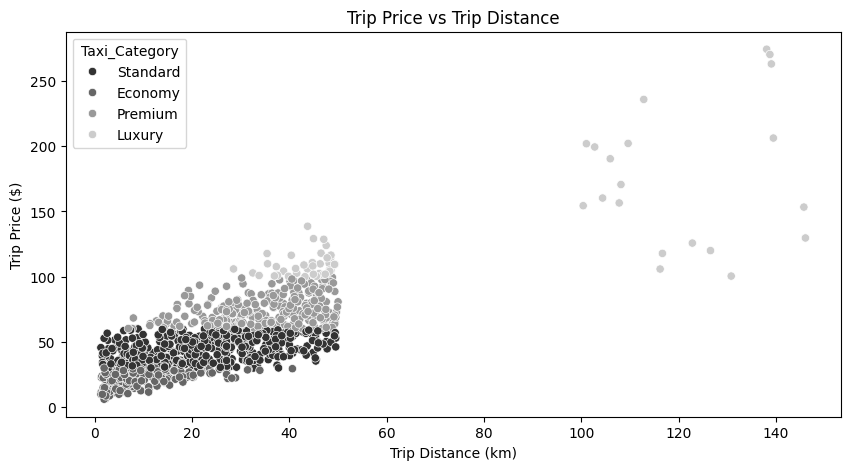

In [15]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df,  x='Trip_Distance_km',y='Trip_Price',hue='Taxi_Category',  palette='gray')
plt.title('Trip Price vs Trip Distance')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Price ($)')
plt.show()

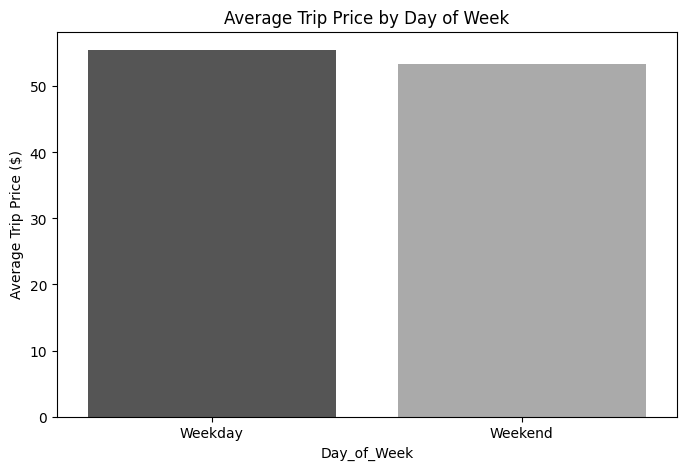

In [16]:
plt.figure(figsize=(8,5))
sns.barplot(x='Day_of_Week', y='Trip_Price', data=df, ci=None, palette='gray')
plt.title('Average Trip Price by Day of Week')
plt.ylabel('Average Trip Price ($)')
plt.show()

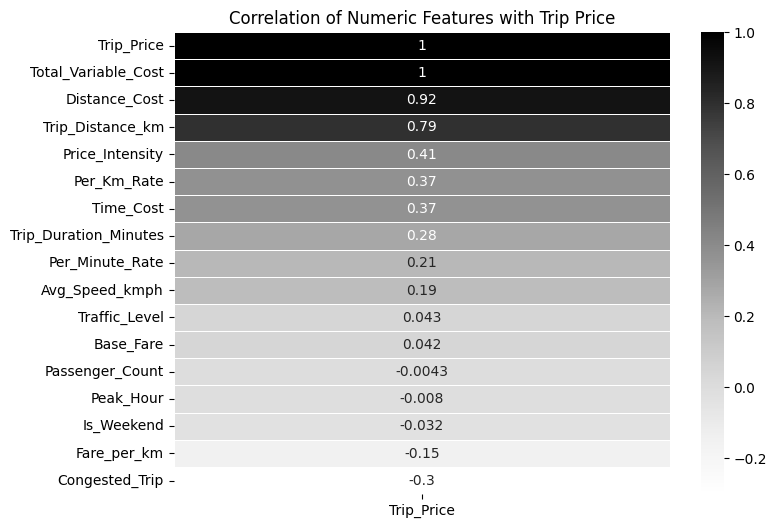

In [17]:
numeric_df = df.select_dtypes(include='number')

corr_matrix = numeric_df.corr()[['Trip_Price']].sort_values(by='Trip_Price', ascending=False)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='Greys', linewidths=0.5)
plt.title('Correlation of Numeric Features with Trip Price')
plt.show()

In [18]:
corr_matrix

,Trip_Price
Trip_Price,1.000000
Total_Variable_Cost,0.999604
Distance_Cost,0.915628
Trip_Distance_km,0.792903
Price_Intensity,0.408218
Per_Km_Rate,0.369569
Time_Cost,0.365534
Trip_Duration_Minutes,0.280900
Per_Minute_Rate,0.208591
Avg_Speed_kmph,0.188554


# **ML Model Dataset**

In [19]:
features_target = ['Trip_Distance_km','Trip_Duration_Minutes','Base_Fare','Per_Km_Rate',
                  'Per_Minute_Rate','Price_Intensity','Passenger_Count','Fare_per_km', 'Traffic_Level','Peak_Hour','Is_Weekend','Congested_Trip',
                  'Time_of_Day','Day_of_Week','Traffic_Conditions','Weather', 'Trip_Price']
non_features = ['Distance_Cost', 'Time_Cost', 'Total_Variable_Cost', 'Avg_Speed_kmph']

df_features = df.drop(columns=non_features)
df_features.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Fare_per_km,Peak_Hour,Is_Weekend,Traffic_Level,Price_Intensity,Congested_Trip,Taxi_Category
0,19.350000,Morning,Weekday,3.0,Low,Clear,3.560000,0.80,0.32,53.82,36.262400,1.874026,1,0,0,1.12,0,Standard
1,47.590000,Afternoon,Weekday,1.0,High,Clear,3.502989,0.62,0.43,40.57,50.453889,1.195099,0,0,2,1.05,0,Standard
2,36.870000,Evening,Weekend,1.0,High,Clear,2.700000,1.21,0.15,37.27,52.903200,1.434858,1,1,2,1.36,0,Standard
3,30.330000,Evening,Weekday,4.0,Low,Clear,3.480000,0.51,0.15,116.81,36.469800,1.202433,1,0,0,0.66,1,Standard
4,27.070547,Evening,Weekday,3.0,High,Clear,2.930000,0.63,0.32,22.64,27.229245,0.576937,1,0,2,0.95,0,Economy


# **Feature-Target Split**

In [20]:
X = df_features.drop(columns='Trip_Price')
y = df_features['Trip_Price']

In [21]:
X.columns

Index(['Trip_Distance_km', 'Time_of_Day', 'Day_of_Week', 'Passenger_Count',
       'Traffic_Conditions', 'Weather', 'Base_Fare', 'Per_Km_Rate',
       'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Fare_per_km', 'Peak_Hour',
       'Is_Weekend', 'Traffic_Level', 'Price_Intensity', 'Congested_Trip',
       'Taxi_Category'],
      dtype='object')

In [22]:
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# **Columns Transformer**

In [23]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [24]:
preprocessor = ColumnTransformer(transformers=[
              ('num', numeric_transformer, numeric_features),
              ('cat', categorical_transformer, categorical_features)])

# **Pipeline**

In [25]:
model = Pipeline([('preprocessor', preprocessor),
                  ('regressor', RandomForestRegressor
                  (n_estimators=100, random_state=42))])

# **Train-Test Split**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# **Pipeline Fitting**

In [27]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Trip_Distance_km',
                                                   'Passenger_Count',
                                                   'Base_Fare', 'Per_Km_Rate',
                                                   'Per_Minute_Rate',
                                                   'Trip_Duration_Minutes',
                                                   'Fare_per_km', 'Peak_Hour',
                                                   'Is_Weekend',
                                                   'Traffic_Level',
                                                   'Price_Intensity',
                                                   'Congested_Trip']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Time_of_Day', 'Day_of_Week',
                                                   'Traffic_Conditions',
                                                   'Weather',
                                                   'Taxi_Category'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# **Target Prediction**

In [28]:
y_pred = model.predict(X_test)

# **Model Evaluation Metrics**

In [29]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"R^2 Score: {r2:.3f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R^2 Score: 0.967
Mean Squared Error: 22.29
Mean Absolute Error: 3.77


# **Joblib Dump Files**

In [30]:
import joblib

joblib.dump(model, 'trip_price_model.joblib')

['trip_price_model.joblib']

In [31]:
joblib.dump(numeric_features, 'numeric_features.joblib')

['numeric_features.joblib']

In [32]:
joblib.dump(categorical_features, 'categorical_features.joblib')

['categorical_features.joblib']

In [33]:
joblib.dump('Trip_Price', 'target_variable.joblib')

['target_variable.joblib']

In [34]:
df_features.to_csv("Taxi Rent Cleaned Data.csv", index=False)